# API Usage Analytics & Anomaly Detection for SaaS Platform

This notebook explores real-world API usage logs collected from an OpenSSH server.  
We preprocess the data, perform exploratory analysis, and detect anomalies using machine learning.

## Data Overview
The dataset `OpenSSH_2k.log_structured.csv` contains 2,000 log events captured from an OpenSSH server over a period of about a month【779450190907598†L319-L323】. Each row includes:

- `LineId`: the index of the log entry
- `Date`, `Day`, `Time`: timestamp information (month abbreviation, day of month, and time)
- `Component`: log source identifier
- `Pid`: process ID
- `Content`: textual description of the event (may contain IP addresses)
- `EventId`: event category (e.g., E10, E13)【870073966178475†L0-L8】
- `EventTemplate`: template for the event text

We treat each log entry as an API request and analyze patterns in API usage.


In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns  # only if needed for extra visuals
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest

# Read the structured log file
file_path = 'OpenSSH_2k.log_structured.csv'
df = pd.read_csv(file_path)

# Display basic information
print('Dataset shape:', df.shape)
print(df.head())


Dataset shape: (2000, 9)
   LineId Date  Day      Time Component    Pid  \
0       1  Dec   10  06:55:46     LabSZ  24200   
1       2  Dec   10  06:55:46     LabSZ  24200   
2       3  Dec   10  06:55:46     LabSZ  24200   
3       4  Dec   10  06:55:46     LabSZ  24200   
4       5  Dec   10  06:55:46     LabSZ  24200   

                                             Content EventId  \
0  reverse mapping checking getaddrinfo for ns.ma...     E27   
1         Invalid user webmaster from 173.234.31.186     E13   
2  input_userauth_request: invalid user webmaster...     E12   
3      pam_unix(sshd:auth): check pass; user unknown     E21   
4  pam_unix(sshd:auth): authentication failure; l...     E19   

                                       EventTemplate  
0  reverse mapping checking getaddrinfo for <*> [...  
1                          Invalid user <*> from <*>  
2  input_userauth_request: invalid user <*> [prea...  
3      pam_unix(sshd:auth): check pass; user unknown  
4  pam_unix(ss

In [ ]:
# Extract IPv4 addresses from the 'Content' column
def extract_ip(text):
    match = re.search(r'(?:\d{1,3}\.){3}\d{1,3}', str(text))
    return match.group(0) if match else None

# Add IP column
df['IP'] = df['Content'].apply(extract_ip)

# Map month abbreviation to integer
month_map = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

# Create a datetime column (assuming year 2023 for demonstration)
def parse_datetime(row):
    month_num = month_map.get(row['Date'], 1)
    day = int(row['Day']) if str(row['Day']).isdigit() else 1
    time_str = row['Time']
    try:
        dt = pd.to_datetime(f"2023-{month_num:02d}-{day:02d} {time_str}")
    except Exception:
        dt = pd.NaT
    return dt

df['DateTime'] = df.apply(parse_datetime, axis=1)

# Drop rows without IP addresses (cannot identify user)
df = df.dropna(subset=['IP']).reset_index(drop=True)
print('After IP extraction and time parsing:', df.shape)
print(df[['IP','DateTime']].head())


After IP extraction and time parsing: (1734, 11)
               IP            DateTime
0  173.234.31.186 2023-12-10 06:55:46
1  173.234.31.186 2023-12-10 06:55:46
2  173.234.31.186 2023-12-10 06:55:46
3  173.234.31.186 2023-12-10 06:55:48
4  173.234.31.186 2023-12-10 06:55:48


In [ ]:
# Aggregate feature metrics per IP address
ip_features = df.groupby('IP').agg(
    total_events = ('IP', 'size'),
    unique_event_ids = ('EventId', 'nunique'),
    first_ts = ('DateTime', 'min'),
    last_ts = ('DateTime', 'max')
)

# Compute session duration in seconds
ip_features['duration_sec'] = (ip_features['last_ts'] - ip_features['first_ts']).dt.total_seconds().fillna(0)

# Display feature summary
print(ip_features.head())


                total_events  unique_event_ids            first_ts  \
IP                                                                   
1.237.174.253              3                 1 2023-12-10 10:19:59   
103.207.39.16             12                 7 2023-12-10 09:18:27   
103.207.39.165             5                 5 2023-12-10 07:56:13   
103.207.39.212            12                 7 2023-12-10 08:33:23   
103.99.0.122             172                 6 2023-12-10 09:11:20   

                           last_ts  duration_sec  
IP                                                
1.237.174.253  2023-12-10 10:50:37        1838.0  
103.207.39.16  2023-12-10 09:18:35           8.0  
103.207.39.165 2023-12-10 07:56:15           2.0  
103.207.39.212 2023-12-10 08:33:31           8.0  
103.99.0.122   2023-12-10 11:04:45        6805.0  


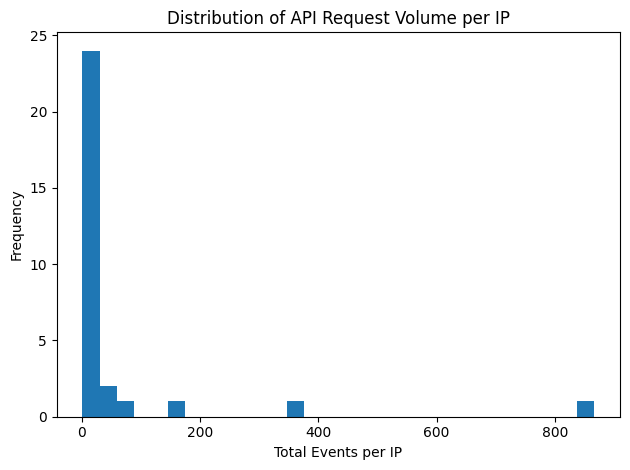

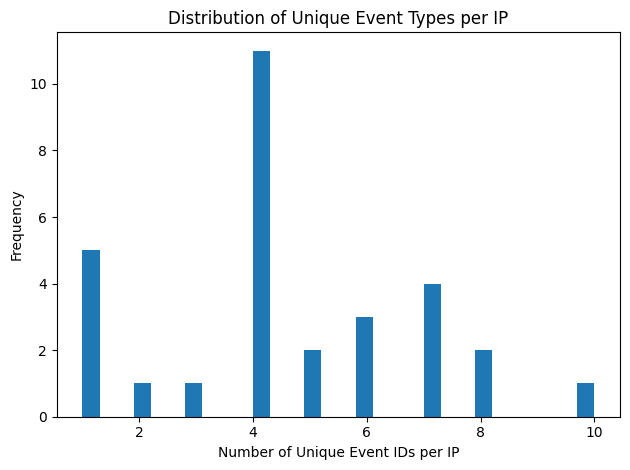

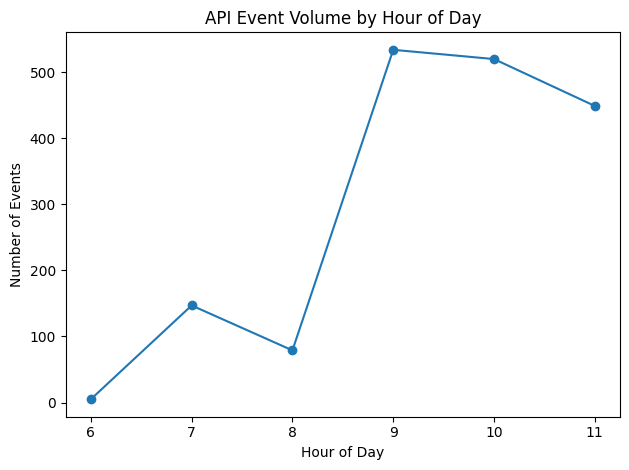

In [ ]:
# Distribution of total events per IP
plt.figure()
plt.hist(ip_features['total_events'], bins=30)
plt.xlabel('Total Events per IP')
plt.ylabel('Frequency')
plt.title('Distribution of API Request Volume per IP')
plt.tight_layout()
plt.show()

# Distribution of unique event IDs per IP
plt.figure()
plt.hist(ip_features['unique_event_ids'], bins=30)
plt.xlabel('Number of Unique Event IDs per IP')
plt.ylabel('Frequency')
plt.title('Distribution of Unique Event Types per IP')
plt.tight_layout()
plt.show()

# Time-of-day analysis: number of events per hour
# Extract hour from DateTime
hour_counts = df['DateTime'].dt.hour.value_counts().sort_index()
plt.figure()
plt.plot(hour_counts.index, hour_counts.values, marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Events')
plt.title('API Event Volume by Hour of Day')
plt.tight_layout()
plt.show()


In [ ]:
# Prepare features for anomaly detection
X = ip_features[['total_events', 'unique_event_ids', 'duration_sec']].values

# Scale features (optional for some algorithms)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Isolation Forest
iso_model = IsolationForest(contamination=0.05, random_state=42)
iso_model.fit(X_scaled)

# Add anomaly labels and scores
ip_features['anomaly_iso'] = iso_model.predict(X_scaled)
ip_features['iso_score'] = iso_model.decision_function(X_scaled)

# Display anomalies (anomaly=-1)
anomalies_iso = ip_features[ip_features['anomaly_iso'] == -1]
print('Anomalous IPs (Isolation Forest):')
print(anomalies_iso.sort_values('iso_score'))


Anomalous IPs (Isolation Forest):
                total_events  unique_event_ids            first_ts  \
IP                                                                   
183.62.140.253           867                 6 2023-12-10 10:54:27   
103.99.0.122             172                 6 2023-12-10 09:11:20   

                           last_ts  duration_sec  anomaly_iso  iso_score  
IP                                                                        
183.62.140.253 2023-12-10 11:04:43         616.0           -1  -0.092253  
103.99.0.122   2023-12-10 11:04:45        6805.0           -1  -0.020587  


In [ ]:
# DBSCAN clustering to detect outliers
# epsilon (eps) and min_samples may need tuning
dbscan_model = DBSCAN(eps=0.8, min_samples=5)
db_labels = dbscan_model.fit_predict(X_scaled)

ip_features['dbscan_cluster'] = db_labels

# Outliers in DBSCAN are labeled as -1
anomalies_dbscan = ip_features[ip_features['dbscan_cluster'] == -1]
print('Anomalous IPs (DBSCAN outliers):')
print(anomalies_dbscan)


Anomalous IPs (DBSCAN outliers):
                 total_events  unique_event_ids            first_ts  \
IP                                                                    
103.99.0.122              172                 6 2023-12-10 09:11:20   
183.136.162.51              8                 4 2023-12-10 07:42:49   
183.62.140.253            867                 6 2023-12-10 10:54:27   
187.141.143.180           349                 7 2023-12-10 09:12:46   
202.100.179.208             8                 4 2023-12-10 07:11:42   
5.188.10.180               53                10 2023-12-10 08:24:32   
52.80.34.196               15                 3 2023-12-10 07:07:38   

                            last_ts  duration_sec  anomaly_iso  iso_score  \
IP                                                                          
103.99.0.122    2023-12-10 11:04:45        6805.0           -1  -0.020587   
183.136.162.51  2023-12-10 10:32:30       10181.0            1   0.091461   
183.62.140.253  202

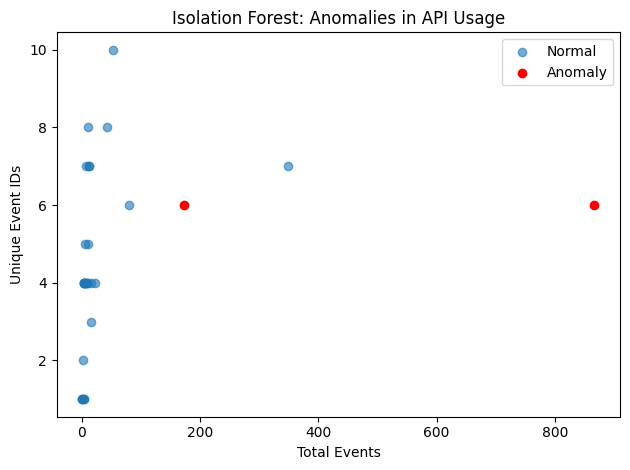

In [ ]:
# Scatter plot of total events vs unique event types
plt.figure()
# Normal points
norm_points = ip_features[ip_features['anomaly_iso'] == 1]
plt.scatter(norm_points['total_events'], norm_points['unique_event_ids'], alpha=0.6, label='Normal')
# Anomalies
anom_points = ip_features[ip_features['anomaly_iso'] == -1]
plt.scatter(anom_points['total_events'], anom_points['unique_event_ids'], color='red', label='Anomaly')
plt.xlabel('Total Events')
plt.ylabel('Unique Event IDs')
plt.title('Isolation Forest: Anomalies in API Usage')
plt.legend()
plt.tight_layout()
plt.show()


## Conclusion

In this analysis we explored a real-world OpenSSH API log dataset and identified abnormal patterns of API usage.  
After preprocessing the log data, we aggregated requests by IP address and computed features such as the total number of events, the number of unique event types, and the duration between the first and last request.  
We applied **Isolation Forest** and **DBSCAN** to detect anomalies, highlighting IP addresses that generated unusually large numbers of requests or diverse event patterns.  
These outliers may correspond to misconfigured clients, malicious actors, or abuse of the API.

Further work could include:
- Incorporating additional features (e.g., response times, error rates, or geolocation) to improve anomaly detection accuracy.
- Evaluating anomalies against a labelled ground truth to estimate false positives and negatives.
- Deploying the model in a streaming environment for real-time monitoring.


In [ ]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 120.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 127.1 MB/s eta 0:00:00


In [ ]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt

def load_data():
    """
    Load the preprocessed IP features and raw log data.
    Returns a tuple of (ip_features_df, raw_df).
    """
    ip_features = pd.read_csv("OpenSSH_ip_features.csv", index_col=0)
    raw_df = pd.read_csv("OpenSSH_2k.log_structured.csv")
    return ip_features, raw_df

def show_summary(ip_features: pd.DataFrame, raw_df: pd.DataFrame):
    st.header("Dataset Summary")
    total_events = len(raw_df)
    unique_ips = ip_features.shape[0]
    num_anomalies = (ip_features["anomaly"] == -1).sum()
    st.write(f"Total log events: **{total_events}**")
    st.write(f"Unique IP addresses: **{unique_ips}**")
    st.write(f"Anomalous IPs detected: **{num_anomalies}**")
    st.subheader("Top 10 IPs by event count")
    top_ips = ip_features.sort_values("total_events", ascending=False).head(10)
    st.dataframe(top_ips[['total_events', 'unique_event_ids', 'duration_sec', 'anomaly']])

def plot_event_distribution(ip_features: pd.DataFrame):
    st.subheader("Event Count Distribution")
    top_n = st.slider("Select number of top IPs to display", 5, 30, 10)
    top_ips = ip_features.sort_values("total_events", ascending=False).head(top_n)
    fig, ax = plt.subplots()
    ax.bar(top_ips.index.astype(str), top_ips["total_events"])
    ax.set_xlabel("IP Address")
    ax.set_ylabel("Total Events")
    ax.set_title(f"Top {top_n} IPs by Event Count")
    plt.xticks(rotation=90)
    st.pyplot(fig)

def plot_anomaly_scatter(ip_features: pd.DataFrame):
    st.subheader("Anomaly Scatter Plot")
    fig, ax = plt.subplots()
    normal = ip_features[ip_features["anomaly"] == 1]
    ax.scatter(normal["total_events"], normal["unique_event_ids"], label="Normal", alpha=0.7)
    anomalies = ip_features[ip_features["anomaly"] == -1]
    ax.scatter(anomalies["total_events"], anomalies["unique_event_ids"], marker='x', label="Anomaly", alpha=0.9)
    ax.set_xlabel("Total Events")
    ax.set_ylabel("Unique Event IDs")
    ax.set_title("Event Count vs Unique Events (Anomaly Detection)")
    ax.legend()
    st.pyplot(fig)

def main():
    st.title("OpenSSH API Usage Analytics & Anomaly Detection")
    st.write("This dashboard analyses real-world OpenSSH log data to detect abnormal API usage patterns and help improve API management.")
    ip_features, raw_df = load_data()
    page = st.sidebar.selectbox(
        "Select a view",
        ("Summary", "Event Distribution", "Anomaly Scatter"),
    )
    if page == "Summary":
        show_summary(ip_features, raw_df)
    elif page == "Event Distribution":
        plot_event_distribution(ip_features)
    elif page == "Anomaly Scatter":
        plot_anomaly_scatter(ip_features)

if __name__ == "__main__":
    main()

2025-11-25 00:55:54.223 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-25 00:55:54.226 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-25 00:55:54.227 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-25 00:55:54.230 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-25 00:55:54.234 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-25 00:55:54.235 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-25 00:55:54.259 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-25 00:55:54.261 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [ ]:
"""
analysis.py
============

This script performs data preprocessing, feature engineering and anomaly detection
on the OpenSSH log dataset.  It loads the structured CSV file, extracts IP
addresses from the log contents, aggregates features per IP address and fits
an Isolation Forest model to detect anomalous IPs.  The resulting feature
matrix with anomaly labels is saved to a CSV file for further analysis or
visualisation.

Usage:
    python analysis.py

Dependencies:
    pandas, numpy, scikit-learn, regex (built into Python), and matplotlib (optional
    if you wish to generate charts from this script).

The script is written for Python 3.10 or higher.
"""

import re
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest


def extract_ip(content: str) -> str:
    """Extract the first IPv4 address from a log message.

    Args:
        content: The log message string.

    Returns:
        The first IP address found in the string or None if no IP is present.
    """
    ip_regex = r"(?:\d{1,3}\.){3}\d{1,3}"
    match = re.search(ip_regex, str(content))
    return match.group(0) if match else None


def load_dataset(path: Path) -> pd.DataFrame:
    """Load the OpenSSH structured log CSV into a DataFrame and add an IP column.

    Args:
        path: Path to the CSV file.

    Returns:
        DataFrame with an additional IP column.
    """
    df = pd.read_csv(path)
    df["IP"] = df["Content"].apply(extract_ip)
    return df


def aggregate_features(df: pd.DataFrame) -> pd.DataFrame:
    """Aggregate per-IP features from the raw log DataFrame.

    The features include total number of events, number of unique event IDs,
    average message length and duration of the session based on the first and
    last occurrences of the IP.

    Args:
        df: Raw DataFrame with an 'IP' column.

    Returns:
        Aggregated DataFrame indexed by IP with feature columns.
    """
    # Convert day and time into a datetime object.  Since the dataset does not
    # include the year, we assume an arbitrary year (e.g., 2023).  Month names
    # are stored in the 'Date' column.
    month_map = {
        'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
        'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12,
    }
    # Build a datetime column
    df = df.copy()
    df["DateTime"] = df.apply(
        lambda r: datetime(
            2023,
            month_map.get(str(r["Date"]).strip(), 1),
            int(r["Day"]),
            int(str(r["Time"]).split(":")[0]),
            int(str(r["Time"]).split(":")[1]),
            int(str(r["Time"]).split(":")[2])
        ),
        axis=1,
    )

    # Compute aggregated metrics per IP
    ip_group = df.dropna(subset=["IP"]).groupby("IP").agg(
        total_events=("IP", "size"),
        unique_event_ids=("EventId", "nunique"),
        avg_msg_length=("Content", lambda x: x.str.len().mean()),
        first_ts=("DateTime", "min"),
        last_ts=("DateTime", "max"),
    )
    ip_group["duration_sec"] = (
        ip_group["last_ts"] - ip_group["first_ts"]
    ).dt.total_seconds().fillna(0)
    return ip_group


def detect_anomalies(features: pd.DataFrame, contamination: float = 0.05) -> pd.DataFrame:
    """Fit an Isolation Forest to detect anomalies based on feature vectors.

    Args:
        features: DataFrame with numerical features for anomaly detection.
        contamination: The proportion of anomalies expected in the data.

    Returns:
        The input DataFrame with additional 'anomaly' and 'anomaly_score' columns.
    """
    model = IsolationForest(contamination=contamination, random_state=42)
    X = features[["total_events", "unique_event_ids", "duration_sec"]].fillna(0)
    model.fit(X)
    features["anomaly"] = model.predict(X)
    # Higher anomaly_score means more normal; negative values are anomalies.
    features["anomaly_score"] = model.decision_function(X)
    return features


def main():
    data_path =  "OpenSSH_2k.log_structured.csv"
    # Load data and compute features
    raw_df = load_dataset(data_path)
    features = aggregate_features(raw_df)
    features_with_anomaly = detect_anomalies(features)
    # Save aggregated features to CSV
    out_path ="OpenSSH_ip_features.csv"
    features_with_anomaly.to_csv(out_path)
    print(f"Aggregated features saved to {out_path}")

main()

Aggregated features saved to OpenSSH_ip_features.csv
